### Multiple tools chatbot using LangGraph
Use builtin Arxiv and Wikipedia as tools

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [7]:
wiki.invoke("Sachin Tendulkar")

'Page: Sachin Tendulkar\nSummary: Sachin Ramesh Tendulkar ( ; Marathi: [sətɕin t̪eɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. He is widely regarded as one of the greatest cricketers of all time, and is the holder of several world records, including being the all-time highest run-scorer in both ODI and Test cricket, receiving the most player of the match awards in international cricket, and being the only batsman to score 100 int'

In [8]:
# Combine all the tools in the list
tools = [arxiv, wiki]

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano")

In [ ]:
# LLM without tools
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a subset of artificial intelligence that involves using algorithms and statistical models to allow computers to learn and make predictions or decisions without being explicitly programmed. Essentially, machine learning enables computers to learn from and analyze data in order to improve their performance on a specific task or problem.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 12, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C85nvbEuo7I5fWWrIF0gZkfg57R7P', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--377e50e1-1748-4797-9fbd-c1b8d06a4207-0', usage_metadata={'input_tokens': 12, 'output_t

In [11]:
# LLM with tools
llm_with_tools = llm.bind_tools(tools=tools)

In [14]:
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content="Attention is all you need researh paper")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xX5iybLWv0QdJHEIuqSD97XI', 'function': {'arguments': '{"query":"Attention is all you need research paper"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 168, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C85tMvlNgFpWEXhkxaHESpnYkC2h1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cfc07546-ae2b-4795-8e8e-6fbb89d5473f-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Attention is all you need research paper'}, 'id': 'call_xX5iybLWv0QdJHEIuqSD97XI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 20, 'to

In [16]:
# Define the state schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages    # reducer

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [19]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

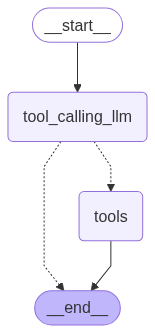

In [20]:
# Build graph
builder = StateGraph(State)

# Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

# compile and draw graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
graph.invoke({"messages": "What is attention is all you need research paper?"})

{'messages': [HumanMessage(content='What is attention is all you need research paper?', additional_kwargs={}, response_metadata={}, id='b636611d-a399-42eb-87f8-5d3b8c7eaf56'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_foeriBB5QDnguGazAPXWsspc', 'function': {'arguments': '{"query":"attention is all you need research paper"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 168, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C86D75xGwIJobdm2ykyEiSl2cWmGs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0d0c6f30-ff81-4155-9ef9-33d7f4902ec5-0', tool_calls=[{'name': 'arxiv', 'args': 

In [23]:
messages = graph.invoke({"messages": "What is attention is all you need research paper?"})

In [30]:
from pprint import pprint
pprint(messages)

{'messages': [HumanMessage(content='What is attention is all you need research paper?', additional_kwargs={}, response_metadata={}, id='353ff9fe-4acb-4039-ba70-c86f8f3a353f'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ymk3EI12duPDdxWmH3gYefE9', 'function': {'arguments': '{"query":"attention is all you need research paper"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 168, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C86CTQshGgKg42coHi6Ns8fboJA5N', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bbaec6ef-ae9b-4892-ad55-216bd40bddb9-0', tool_calls=[{'name': 'arxi